We are trying to solve: <br><br>
$\frac{\partial u(x,y,z)}{\partial x} = A(\frac{\partial^{2} u}{\partial z^{2}}+\frac{\partial^{2} u}{\partial y^{2}}) + F(x,y,z)u$<br><br><br>
Using ADI, this becomes two half step updates (eq 3.25, [Fuhse thesis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwj11OzNzOXdAhWM1IMKHQeFBfwQFjAAegQICRAC&url=https%3A%2F%2Fediss.uni-goettingen.de%2Fbitstream%2Fhandle%2F11858%2F00-1735-0000-0006-B592-3%2Ffuhse.pdf%3Fsequence%3D1&usg=AOvVaw1HRt8mkDnQc_LoM-RhOpcu)), with the first one being : <br><br>
$(1-\frac{r_{y}}{2}\delta^{2}_{y}+C^{n+\frac{1}{2}}_{jk})*u^{n+\frac{1}{2}}_{jk} = (1+\frac{r_{z}}{2}\delta^{2}_{z}+C^{n}_{jk})*u^{n}_{jk}$<br><br>
This can be written as a series of linear matrix equations :<br><br>
$B^{n}_{k}*u^{n+\frac{1}{2}}_{k} = r_{k}$, for $k = 1,....., M_{z}-1$<br><br>
and for the second half step, it becomes:<br><br>
$B^{'n}_{j}*u^{n+1}_{j} = r^{'}_{j}$, for $k = 1,....., M_{z}-1$<br>
<br><br>
Define: <br><br>
$r_{y} = A\frac{\Delta x}{\Delta y^{2}}$<br>
$r_{z} = A\frac{\Delta x}{\Delta z^{2}}$<br>
$C^{n}_{jk} = \frac{F^{n}_{k}\Delta x}{4}$<br>
$A = \frac{-i}{2k}$<br>
$F(x,y,z) = -1*\frac{ik}{2}(n^{2}(x,y,z)-1)$

In [1]:
import numpy as np
import urllib
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
from tqdm import trange, tqdm
from scipy.signal import gaussian
from scipy.sparse import diags
import scipy.sparse.linalg as splinalg
from scipy.special import fresnel
from pyfftw.interfaces.numpy_fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage.filters import laplace
np.set_printoptions(2)

In [2]:
def plot_img(a):
    plt.figure()
    plt.imshow(a)
    plt.show()

def plot_mod_and_phase(arr, figsize=(12, 5), title=None, unwrap=False):
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1)
    subfig1 = ax1.imshow(np.abs(arr))
    plt.colorbar(subfig1)
    plt.title('Modulus')
    ax2 = fig.add_subplot(1, 2, 2)
    phase_term = np.angle(arr)
    if unwrap:
        phase_term = np.unwrap(phase_term)
    subfig2 = ax2.imshow(phase_term)
    plt.colorbar(subfig2)
    plt.title('Phase')
    if title is not None:
        plt.suptitle(title)
    plt.show()

In [3]:
E = 5000
wavel = (1239.84/E)*1e-9
k = ((2*np.pi)/wavel)
A = -1j/(2*k)

In [4]:
dim_x = 256
dim_y = 256
dim_z = 256

x = np.linspace(0,255e-9,dim_x)
y = np.linspace(0,255e-9,dim_y)
z = np.linspace(0,255e-9,dim_z)

Δx = x[1] - x[0]
Δy = y[1] - y[0]
Δz = z[1] - z[0]


r_y = A * (Δx/(Δy)**2) 
r_z = A * (Δx/(Δz)**2) 

coords = [y[0]*1e6,y[-1]*1e6,z[0]*1e6,z[-1]*1e6]

In [5]:
F = np.zeros((dim_x,dim_y,dim_z),dtype=np.complex128)

In [6]:
grid_beta = np.load('phantom/grid_beta.npy')
grid_delta = np.load('phantom/grid_delta.npy')

In [7]:
for i in range(256):
    F[i,:,:] = -1j*(k/2)*((1-grid_delta[:,:,i]-1j*grid_beta[:,:,i])**2-np.array(np.ones((256,256)),dtype=np.complex128))

In [8]:
wave = np.ones((dim_y,dim_z),dtype=np.complex128)
wave_new = np.ones((dim_y,dim_z),dtype=np.complex128)
Y,Z = np.meshgrid(y,z)
wave_history = np.ones((dim_x,dim_y,dim_z),dtype=np.complex128)

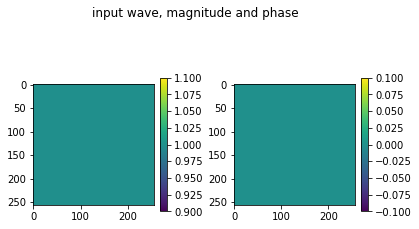

In [9]:
fig,(ax1,ax2) = plt.subplots(1,2)
im1 = ax1.imshow(np.abs(wave))
fig.colorbar(im1, ax=ax1,fraction=0.05)
im2 = ax2.imshow(unwrap_phase(np.angle(wave)))
fig.colorbar(im2, ax=ax2,fraction=0.05)
fig.suptitle('input wave, magnitude and phase')
fig.subplots_adjust(wspace=0.5)
plt.show()

In [10]:
def step_1(wave_new,wave,B,dim_z,r_y,r_z,k):
    c = ((Δx/4)*F[i,1:-1,k])
    d = wave[1:-1,k]*(1+c) + (r_z/2)*(wave[1:-1,k-1]-2*wave[1:-1,k]+wave[1:-1,k+1])
    d[0]  += (r_y/2)*wave[0,k]
    d[-1] += (r_y/2)*wave[-1,k]
    B = B - diags(c,offsets=0)
    wave_new[1:-1,k] = splinalg.spsolve(B,d)

def step_2(wave_new,wave,B,dim_y,r_y,r_z,j):
    c = ((Δx/4)*F[i,j,1:-1])
    d = wave[j,1:-1]*(1+c) + (r_y/2)*(wave[j-1,1:-1]-2*wave[j,1:-1]+wave[j+1,1:-1])
    d[0]  += (r_z/2)*wave[j,0]
    d[-1] += (r_z/2)*wave[j,-1]
    B = B - diags(c,offsets=0)
    wave_new[j,1:-1] = splinalg.spsolve(B,d)

In [11]:
for i in trange(dim_x):
    b_diag = np.ones(dim_z-2)*(1 + r_y)
    B = diags(b_diag,offsets=0) + diags(-r_y/2*np.ones(dim_z-3),offsets=1) + diags(-r_y/2*np.ones(dim_z-3),offsets=-1)
    for k in range(1,dim_z-1):
        step_1(wave_new,wave,B,dim_z,r_y,r_z,k)

    b_diag = np.ones(dim_y-2)*(1 + r_z)
    B = diags(b_diag,offsets=0) + diags(-r_z/2*np.ones(dim_y-3),offsets=1) + diags(-r_z/2*np.ones(dim_y-3),offsets=-1) 
    for j in range(1,dim_y-1):
        step_2(wave,wave_new,B,dim_y,r_y,r_z,j)
    
    wave_history[i,1:-1,1:-1] = wave[1:-1,1:-1]

100%|██████████| 256/256 [01:15<00:00,  3.41it/s]


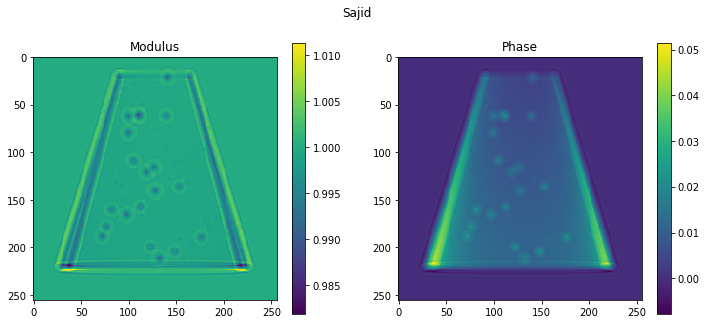

In [12]:
plot_mod_and_phase(wave_history[-1,:,:], title='Sajid')

In [18]:
# for test only. Empty space.
F = np.zeros((dim_x,dim_y,dim_z),dtype=np.complex128)
for i in trange(dim_x):
    b_diag = np.ones(dim_z-2)*(1 + r_y)
    B = diags(b_diag,offsets=0) + diags(-r_y/2*np.ones(dim_z-3),offsets=1) + diags(-r_y/2*np.ones(dim_z-3),offsets=-1)
    for k in range(1,dim_z-1):
        step_1(wave_new,wave,B,dim_z,r_y,r_z,k)

    b_diag = np.ones(dim_y-2)*(1 + r_z)
    B = diags(b_diag,offsets=0) + diags(-r_z/2*np.ones(dim_y-3),offsets=1) + diags(-r_z/2*np.ones(dim_y-3),offsets=-1) 
    for j in range(1,dim_y-1):
        step_2(wave,wave_new,B,dim_y,r_y,r_z,j)
    
    wave_history[i,1:-1,1:-1] = wave[1:-1,1:-1]

100%|██████████| 256/256 [01:13<00:00,  3.49it/s]


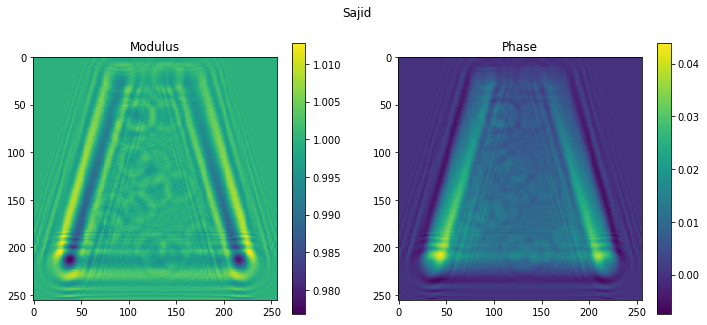

In [19]:
plot_mod_and_phase(wave_history[-1,:,:], title='Sajid')

In [26]:
# ming_out = np.load('ming_output.npy')

# fig,(ax) = plt.subplots(2,2)

# im1 = ax[0,0].imshow(np.abs(wave_history[-1,:,:]))
# ax[0,0].set_title('Finite Difference, Magnitude')
# fig.colorbar(im1, ax=ax[0,0],fraction=0.05)

# im2 = ax[0,1].imshow(np.abs(ming_out))
# ax[0,1].set_title('Multislice (Ming), Magnitude')
# fig.colorbar(im2, ax=ax[0,1],fraction=0.05)

# im3 = ax[1,0].imshow(unwrap_phase(np.angle(wave_history[-1,:,:])))
# ax[1,0].set_title('Finite Difference, Phase')
# fig.colorbar(im3, ax=ax[1,0],fraction=0.05)

# im4 = ax[1,1].imshow(unwrap_phase(np.angle(ming_out)))
# ax[1,1].set_title('Multislice (Ming), Phase')
# fig.colorbar(im4, ax=ax[1,1],fraction=0.05)

# fig.subplots_adjust(hspace=0.2)
# fig.subplots_adjust(wspace=0.2)
# plt.rcParams["figure.figsize"] = (16,16)
# plt.show()

## Cross-check with analytical result

We use a square aperture to compare FD and Fresnel. See Goodman section 4.5.1. Suppose we have a square aperture with width 2w = 128 nm. The energy and pixel size are defined below:

In [20]:
energy_ev = 5000
psize_nm = 1.
w_nm = 64
lmbda_nm = 1240. / energy_ev
z_nm = 1651.61

In [21]:
PI = 3.1415927

def plot_profile(arr, range=None):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.abs(arr[int(arr.shape[0] / 2), :]))
    if range is not None:
        plt.xlim(range)
    plt.subplot(1, 2, 2)
    plt.plot(np.angle(arr[int(arr.shape[0] / 2), :]))
    if range is not None:
        plt.xlim(range)
    plt.show()
    
    
def gen_mesh(max, shape):
    """Generate mesh grid.
    """
    yy = np.linspace(-max[0], max[0], shape[0])
    xx = np.linspace(-max[1], max[1], shape[1])
    res = np.meshgrid(xx, yy)
    return res

    
def get_kernel_fourier(dist_nm, lmbda_nm, voxel_nm, grid_shape):
    """Get Fresnel propagation kernel for TF algorithm.

    Parameters:
    -----------
    simulator : :class:`acquisition.Simulator`
        The Simulator object.
    dist : float
        Propagation distance in cm.
    """
    k = 2 * PI / lmbda_nm
    u_max = 1. / (2. * voxel_nm[0])
    v_max = 1. / (2. * voxel_nm[1])
    u, v = gen_mesh([v_max, u_max], grid_shape[0:2])
    # H = np.exp(1j * k * dist_nm * np.sqrt(1 - lmbda_nm**2 * (u**2 + v**2)))
    H = np.exp(1j * k * dist_nm) * np.exp(-1j * PI * lmbda_nm * dist_nm * (u ** 2 + v ** 2))

    return H


def get_kernel_real(dist_nm, lmbda_nm, voxel_nm, grid_shape):

    k = 2 * PI / lmbda_nm
    x, y = gen_mesh([voxel_nm[0] * int(grid_shape[0] / 2), voxel_nm[1] * int(grid_shape[1] / 2)], grid_shape[0:2])
    h = np.exp(1j * k * dist_nm) / (1j * lmbda_nm * dist_nm) * np.exp(1j * k * (x ** 2 + y ** 2) / (2 * dist_nm))

    return h


def free_propagate_fresnel(wavefront, dist_cm, wavelen_nm, psize_cm, h=None):
    
    dist_nm = dist_cm * 1.e7
    psize_nm = psize_cm * 1.e7
    if h is None:
        h = get_kernel_fourier(dist_nm, wavelen_nm, [psize_nm, psize_nm], wavefront.shape)
    wavefront = fftshift(fft2(wavefront)) * h
    wavefront = ifft2(ifftshift(wavefront))
    return wavefront


def free_propagate_fresnel_ir(wavefront, dist_cm, wavelen_nm, psize_cm, h=None):
    
    dist_nm = dist_cm * 1.e7
    psize_nm = psize_cm * 1.e7
    if h is None:
        h = get_kernel_real(dist_nm, wavelen_nm, [psize_nm, psize_nm], wavefront.shape)
    wavefront = fft2(fftshift(wavefront)) * fft2(fftshift(h))
    wavefront = ifftshift(ifft2(wavefront))
    return wavefront

The function below generate a plot of the detector plane intensity distribution according to the analytical result.

In [22]:
def square_aperture_analytical(z_nm, lmbda_nm, w_nm, psize_nm, wave_size=(512, 512)):
    
    k = 2 * np.pi / lmbda_nm
    n_f = w_nm ** 2 / (lmbda_nm * z_nm)
    y = np.arange(wave_size[0])
    x = np.arange(wave_size[1])
    y = (y - (wave_size[0] - 1.) / 2.) * psize_nm
    x = (x - (wave_size[1] - 1.) / 2.) * psize_nm
    xx, yy = np.meshgrid(x, y)
    X = xx / np.sqrt(lmbda_nm * z_nm)
    Y = yy / np.sqrt(lmbda_nm * z_nm)
    alpha_1 = -np.sqrt(2) * (np.sqrt(n_f) + X)
    alpha_2 = np.sqrt(2) * (np.sqrt(n_f) - X)
    beta_1 = -np.sqrt(2) * (np.sqrt(n_f) + Y)
    beta_2 = np.sqrt(2) * (np.sqrt(n_f) - Y)
    sa1, ca1 = fresnel(alpha_1)
    sa2, ca2 = fresnel(alpha_2)
    sb1, cb1 = fresnel(beta_1)
    sb2, cb2 = fresnel(beta_2)
    u = np.exp(1j * k * z_nm) / 2j * ((ca2 - ca1) + 1j * (sa2 - sa1)) * ((cb2 - cb1) + 1j * (sb2 - sb1))
    return u

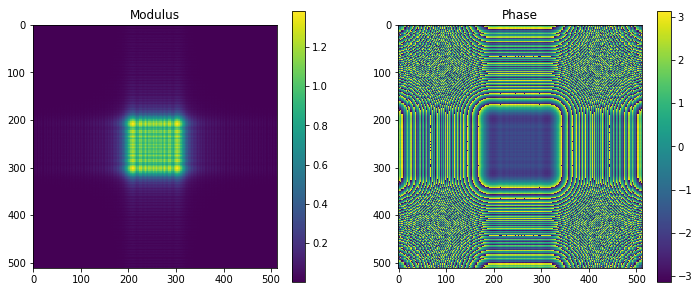

Fresnel number is 10.0000175781559


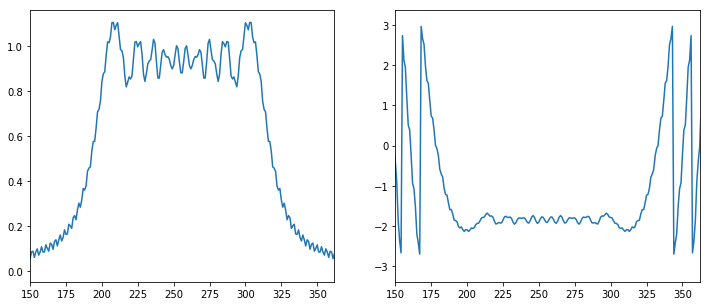

In [23]:
wavefront_analytical = square_aperture_analytical(z_nm, lmbda_nm, w_nm, psize_nm, wave_size=(512, 512))
plot_mod_and_phase(wavefront_analytical)
print('Fresnel number is {}'.format(w_nm ** 2 / (lmbda_nm * z_nm)))
plot_profile(wavefront_analytical, range=(150, 362))

Now we do the samething with our Fresnel implementation.

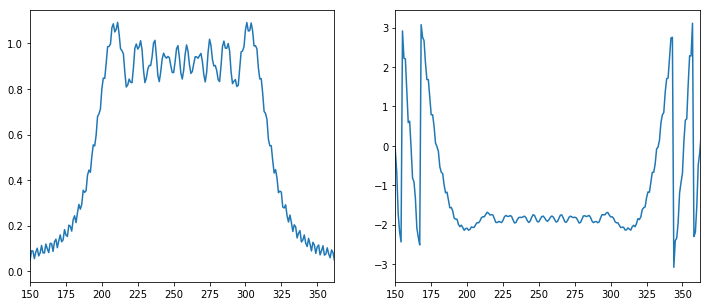

In [24]:
obj = np.zeros([512, 512])
w = int(w_nm / psize_nm)
obj[int(obj.shape[0] / 2) - w:int(obj.shape[0] / 2) + w, int(obj.shape[1] / 2) - w:int(obj.shape[1] / 2) + w] = 1
wavefront_fresnel = free_propagate_fresnel(obj, z_nm * 1e-7, lmbda_nm, psize_nm * 1e-7, h=None)
plot_profile(wavefront_fresnel, range=(150, 362))

Now compare with the results of FD. Firstly we show the outcome from solving the Helmholtz equation exactly using ADI.

100%|██████████| 512/512 [05:49<00:00,  1.46it/s]


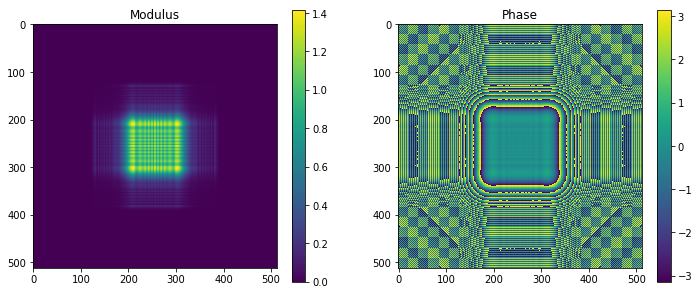

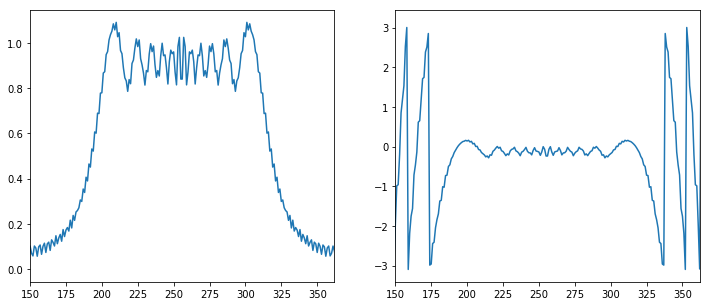

In [25]:
dim_x = 512
dim_y = 512
dim_z = 512

Δx = z_nm * 1e-9 / dim_x
Δy = psize_nm * 1e-9
Δz = psize_nm * 1e-9

x = np.linspace(0, dim_x * Δx, dim_x)
y = np.linspace(0, dim_y * Δy, dim_y)
z = np.linspace(0, dim_z * Δz, dim_z)

r_y = A * (Δx/(Δy)**2) 
r_z = A * (Δx/(Δz)**2) 

coords = [y[0]*1e6,y[-1]*1e6,z[0]*1e6,z[-1]*1e6]

F = np.zeros((dim_x, dim_y, dim_z), dtype=np.complex128)

grid_delta = np.zeros([dim_y, dim_z, dim_x])
grid_beta = np.zeros([dim_y, dim_z, dim_x])
grid_delta[:, :, 0] = obj

# F[0,:,:] = -1j*(k/2)*((1-grid_delta[:,:,0]-1j*grid_beta[:,:,0])**2-np.array(np.ones((dim_y, dim_z)),dtype=np.complex128))

wave = np.ones((dim_y, dim_z),dtype=np.complex128)
wave_new = np.ones((dim_y, dim_z),dtype=np.complex128)
wave = obj.astype(np.complex128)
wave_new = obj.astype(np.complex128)
Y,Z = np.meshgrid(y,z)
wave_history = np.ones((dim_x,dim_y,dim_z),dtype=np.complex128)

def step_1(wave_new,wave,B,dim_z,r_y,r_z,k):
    c = ((Δx/4)*F[i,1:-1,k])
    d = wave[1:-1,k]*(1+c) + (r_z/2)*(wave[1:-1,k-1]-2*wave[1:-1,k]+wave[1:-1,k+1])
    d[0]  += (r_y/2)*wave[0,k]
    d[-1] += (r_y/2)*wave[-1,k]
    B = B - diags(c,offsets=0)
    wave_new[1:-1,k] = splinalg.spsolve(B,d)

def step_2(wave_new,wave,B,dim_y,r_y,r_z,j):
    c = ((Δx/4)*F[i,j,1:-1])
    d = wave[j,1:-1]*(1+c) + (r_y/2)*(wave[j-1,1:-1]-2*wave[j,1:-1]+wave[j+1,1:-1])
    d[0]  += (r_z/2)*wave[j,0]
    d[-1] += (r_z/2)*wave[j,-1]
    B = B - diags(c,offsets=0)
    wave_new[j,1:-1] = splinalg.spsolve(B,d)

for i in trange(dim_x):
    b_diag = np.ones(dim_z-2)*(1 + r_y)
    B = diags(b_diag,offsets=0) + diags(-r_y/2*np.ones(dim_z-3),offsets=1) + diags(-r_y/2*np.ones(dim_z-3),offsets=-1)
    for k in range(1,dim_z-1):
        step_1(wave_new,wave,B,dim_z,r_y,r_z,k)

    b_diag = np.ones(dim_y-2)*(1 + r_z)
    B = diags(b_diag,offsets=0) + diags(-r_z/2*np.ones(dim_y-3),offsets=1) + diags(-r_z/2*np.ones(dim_y-3),offsets=-1) 
    for j in range(1,dim_y-1):
        step_2(wave,wave_new,B,dim_y,r_y,r_z,j)
    
    wave_history[i,1:-1,1:-1] = wave[1:-1,1:-1]

wavefront_fd = wave_history[-1,:,:]
plot_mod_and_phase(wavefront_fd)
plot_profile(wavefront_fd, range=(150, 362))

Then compare the results with a simplistic version, where we assume dz is small and calculate du/dz before doing `u = u0 + dudz * dz`.

In [26]:
def finite_difference_propagation(wavefront, delta_slice, beta_slice, dist_nm, lmbda_nm, psize_nm):
    n_slice = 1 - delta_slice - 1j * beta_slice
    k = 2 * PI / lmbda_nm
    dudz = 1 / (2j * k * n_slice) * \
           (laplace(np.real(wavefront)) + 1j * laplace(np.imag(wavefront))) - \
           1j * k * (n_slice - 1) * wavefront / (psize_nm ** 2)
    wavefront = wavefront + dudz * dist_nm
    return wavefront


100%|██████████| 256/256 [00:09<00:00, 27.97it/s]


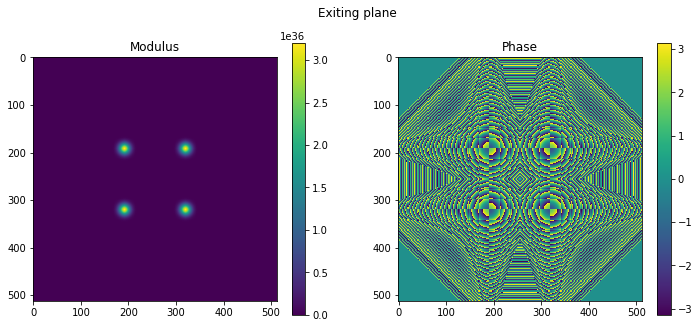

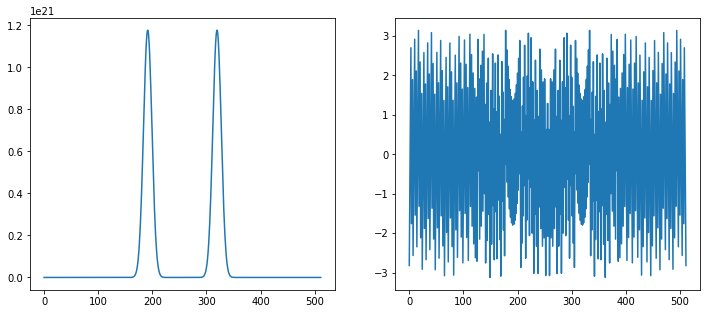

In [28]:
wavefront = np.copy(obj).astype(np.complex128)
dim_x, dim_y, dim_z = (512, 512, 256)
grid_delta = np.zeros([dim_x, dim_y, dim_z])
grid_beta = np.zeros([dim_x, dim_y, dim_z])
for i_slice in tqdm(range(grid_delta.shape[2])):
    delta_slice = grid_delta[:, :, i_slice]
    beta_slice = grid_beta[:, :, i_slice]
#     wavefront *= np.exp((kz * delta_slice) * 1j) * np.exp(-kz * beta_slice)
    wavefront = finite_difference_propagation(wavefront, 
                                              delta_slice,
                                              beta_slice,
                                              z_nm / dim_z, 
                                              lmbda_nm,
                                              psize_nm)
plot_mod_and_phase(wavefront, title='Exiting plane', unwrap=False)
plot_profile(wavefront)